# TASK 6.6: Sourcing & Analysing Time-Series Data

## This script contain:
### 1. Importing Libraries & Data
### 2. Subsetting, wrangling, and cleaning time-series data
### 3. Time series analysis: decomposition
### 4. Testing for stationarity
### 5. Stationarizing COVID-19 Data

## 1. Importing Libraries & Data

### Libraries

In [1]:
# import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm 
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

### Data

In [2]:
# create path
path = r'C:\Users\M de Villiers\Desktop\Data Analytics\Achievement 6\02_Data\Prepared_Data'

In [3]:
data = pd.read_csv(os.path.join(path, 'FINAL_COVID_19_DATA.csv'), index_col = False)

In [4]:
data.head()

,country,iso_code,month_year,vaccines,total_vaccinations,people_vaccinated,people_fully_vaccinated,monthly_vaccinations_raw,monthly_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,monthly_vaccinations_per_million,continent,population,new_cases,total_cases,new_deaths,total_deaths,%deaths
0,Afghanistan,AFG,2021-02,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",8200,8200,0,0,8202,0.02,0.02,0.00,204,Asia,39835428,691,55714,43,2443,0.006133
1,Afghanistan,AFG,2021-03,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",54000,54000,0,0,85894,0.14,0.14,0.00,2154,Asia,39835428,740,56454,41,2484,0.006236
2,Afghanistan,AFG,2021-04,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",240000,240000,0,0,219606,0.60,0.60,0.00,5511,Asia,39835428,3291,59745,141,2625,0.006590
3,Afghanistan,AFG,2021-05,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",600152,480226,119926,2859,285838,1.51,1.21,0.30,7171,Asia,39835428,12093,71838,319,2944,0.007390
4,Afghanistan,AFG,2021-06,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",886854,699200,187654,4015,242899,2.23,1.76,0.47,6097,Asia,39835428,46821,118659,1927,4871,0.012228


In [5]:
data.shape

(5468, 20)

# For this task I would like to do time-series analysis of two variables in my dataset: total vaccinations and total deaths

# Total Vaccinations

## 2. Subsetting, wrangling, and cleaning time-series data

In [6]:
df = data.groupby(['month_year'], as_index=True).agg(total_vaccinations = ('total_vaccinations', 'sum'))

In [7]:
df.head()

,total_vaccinations
month_year,
2020-01,0
2020-02,0
2020-03,0
2020-04,0
2020-05,0


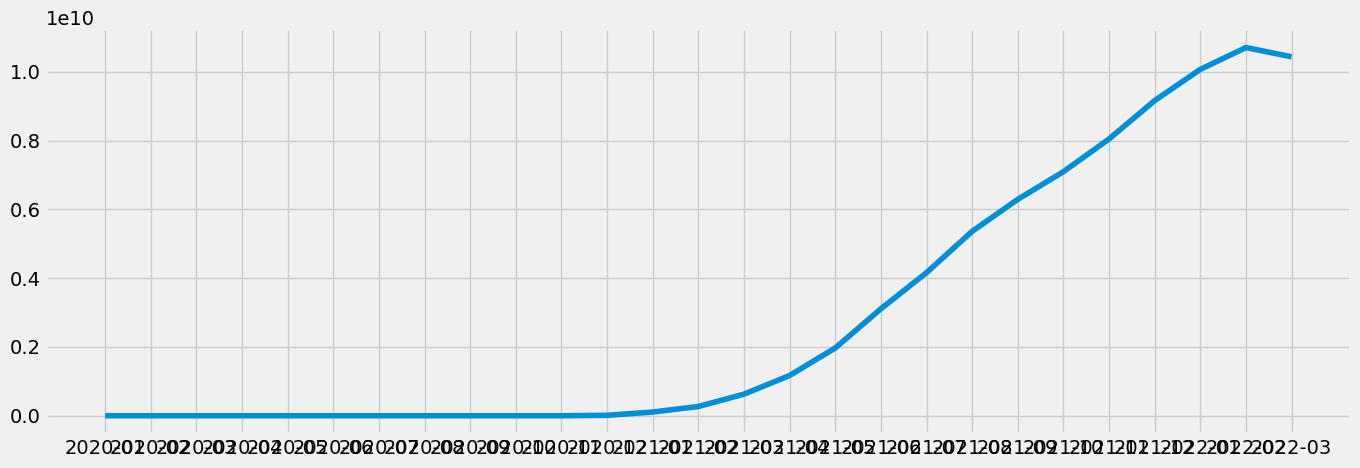

In [8]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df)

In [9]:
# reset index
df_reset = df.reset_index()

In [10]:
df_reset.head()

,month_year,total_vaccinations
0,2020-01,0
1,2020-02,0
2,2020-03,0
3,2020-04,0
4,2020-05,0


In [11]:
df_sub = df_reset.loc[(df_reset['month_year'] >= '2020-01') & (df_reset['month_year'] < '2022-03')]

I chose not to use data from March 2022 because at the time of data sourcing, not all countries have reported their numbers for March 2022 yet, thus there were many missing values that would have skewed the data.

In [12]:
df_sub.head()

,month_year,total_vaccinations
0,2020-01,0
1,2020-02,0
2,2020-03,0
3,2020-04,0
4,2020-05,0


In [13]:
# Set the "month_year" column as the index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['month_year'])
df_sub = df_sub.set_index('datetime')
df_sub.drop(['month_year'], axis=1, inplace=True)
df_sub.head()

,total_vaccinations
datetime,
2020-01-01,0
2020-02-01,0
2020-03-01,0
2020-04-01,0
2020-05-01,0


In [14]:
df_sub.tail()

,total_vaccinations
datetime,
2021-10-01,7095129159
2021-11-01,8046667272
2021-12-01,9162721281
2022-01-01,10070668260
2022-02-01,10705527331


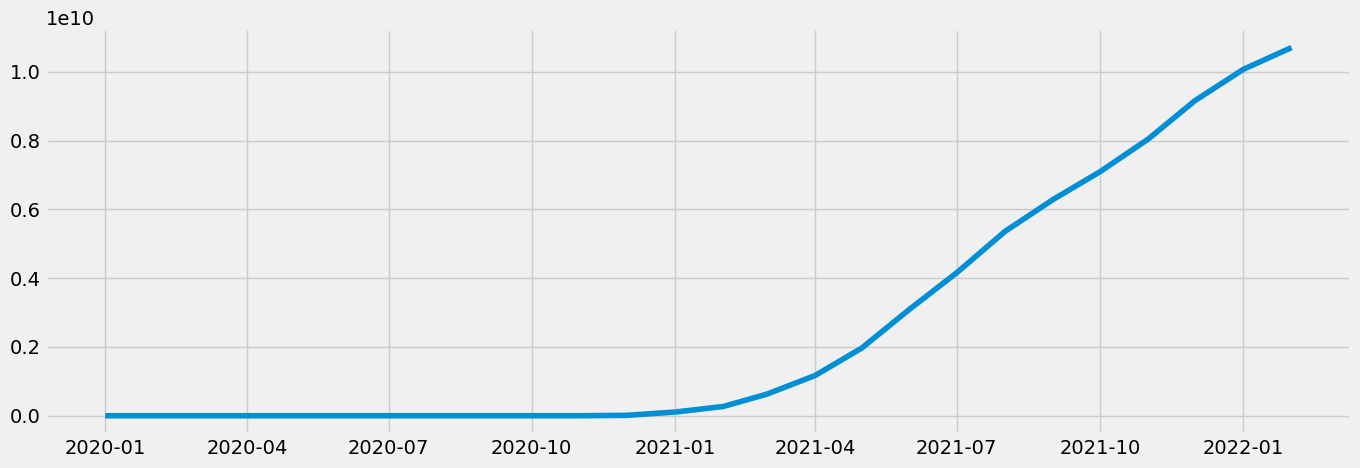

In [15]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

In [16]:
# check for missing values
df_sub.isnull().sum()
# no missing values

total_vaccinations    0
dtype: int64

In [17]:
# Check for duplicates
dups = df_sub.duplicated()
dups.sum()
# no duplicates

10

These duplicates aren't true duplicates. COVID-19 started in 2019, but vaccination rollouts only started in December 2020. The 'duplicates' are for the months January to November of 2020 and all values are 0.

## 3. Time-series analysis: decomposition

In [18]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_sub, model='additive')

In [19]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

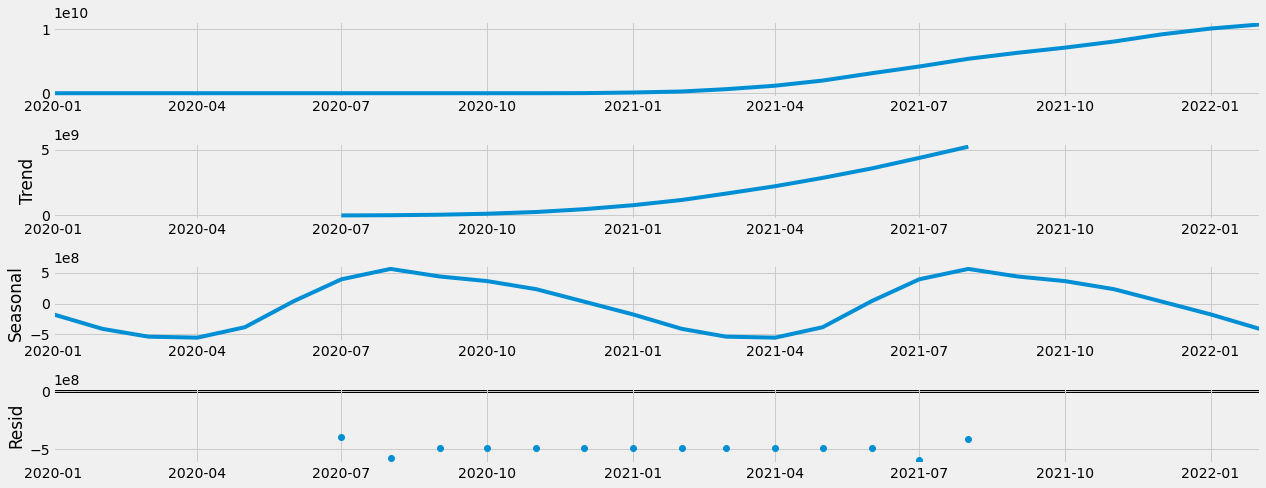

In [20]:
# Plot the separate components
decomposition.plot()
plt.show()

The first chart is the 'level', or the data with all its compositions - this shows a very gradual increase from about March 2021.

The second chart indicates the 'trend' of the data. This data shows a gradual upward trend from the end of 2020.

The third chart indicates 'seasonality'. This data does not have a lot of data points and also does not date back very far. It does however seem as though it has seasonality as the numbers seem to increase around August every year.

The last chart is residual noise.

## 4. Testing for Stationarity

In [21]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):

    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(df_sub['total_vaccinations'])

Dickey-Fuller Stationarity test:
Test Statistic                -6.283756e+00
p-value                        3.741398e-08
Number of Lags Used            9.000000e+00
Number of Observations Used    1.600000e+01
Critical Value (1%)           -3.924019e+00
Critical Value (5%)           -3.068498e+00
Critical Value (10%)          -2.673893e+00
dtype: float64


My Test Statistic is far smaller than the Critical Value (all three critical values), but from the charts and trends it is clear that my data is not stationary.

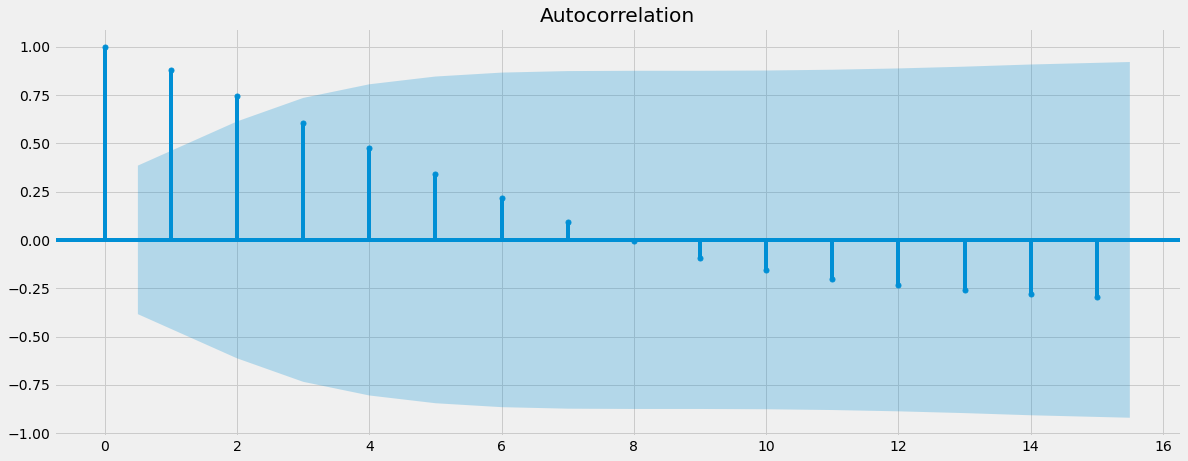

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_sub)
plt.show()

I am not quite sure what this means. I know my data is not stationary, but according to the dicky-fuller test and this chart, differencing is not necessary?

## 5. Stationarizing COVID-19 Data

In [23]:
df_diff = df_sub - df_sub.shift(1)

In [24]:
df_diff.dropna(inplace = True)

In [25]:
df_diff.head()

,total_vaccinations
datetime,
2020-02-01,0.0
2020-03-01,0.0
2020-04-01,0.0
2020-05-01,0.0
2020-06-01,0.0


In [26]:
df_diff.tail()

,total_vaccinations
datetime,
2021-10-01,8.035832e+08
2021-11-01,9.515381e+08
2021-12-01,1.116054e+09
2022-01-01,9.079470e+08
2022-02-01,6.348591e+08


In [27]:
df_diff.columns

Index(['total_vaccinations'], dtype='object')

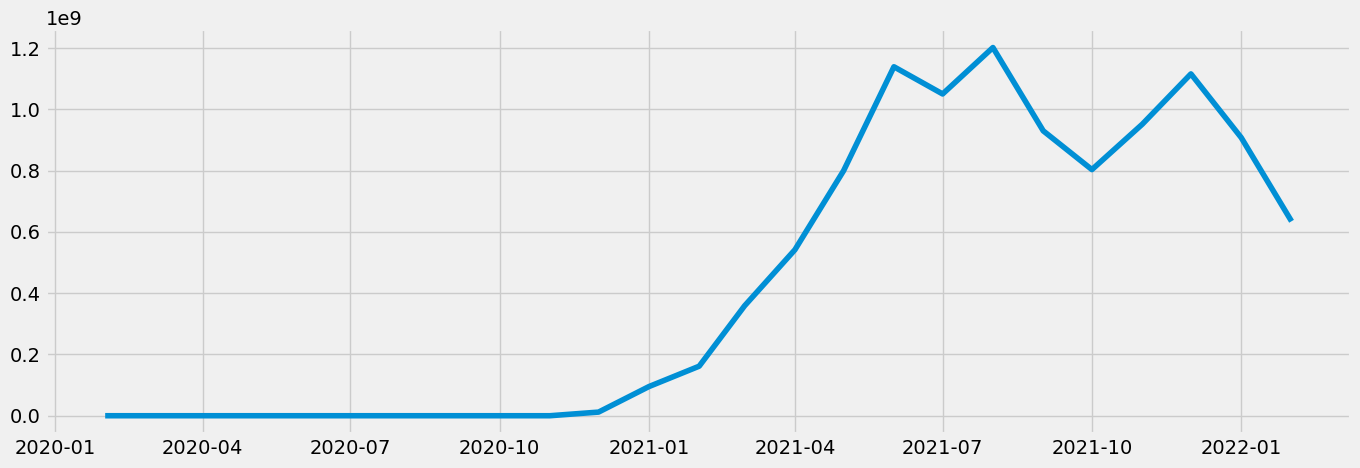

In [28]:
# Check what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [29]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -7.605154e+00
p-value                        2.332842e-11
Number of Lags Used            9.000000e+00
Number of Observations Used    1.500000e+01
Critical Value (1%)           -3.964443e+00
Critical Value (5%)           -3.084908e+00
Critical Value (10%)          -2.681814e+00
dtype: float64


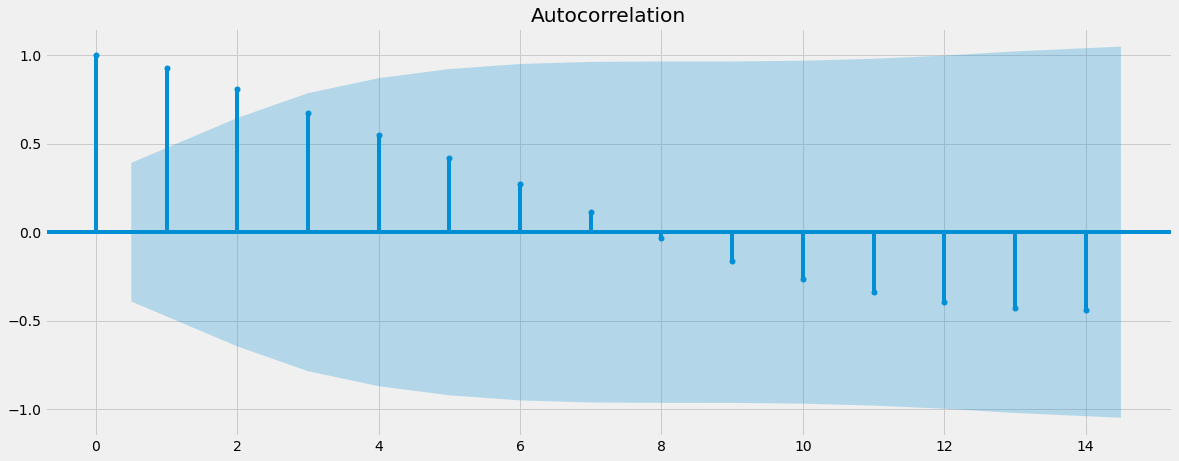

In [30]:
plot_acf(df_diff)
plt.show()

This does not look much different from before the differencing, so I am guessing differencing was not necessary.

#### I want to add the bonus task here but need advice first.

# Total Deaths

## 2. Subsetting, wrangling, and cleaning time-series data

In [31]:
df1 = data.groupby(['month_year'], as_index=True).agg(total_deaths = ('total_deaths', 'sum'))

In [32]:
df1.head()

,total_deaths
month_year,
2020-01,213
2020-02,2937
2020-03,44843
2020-04,241866
2020-05,393037


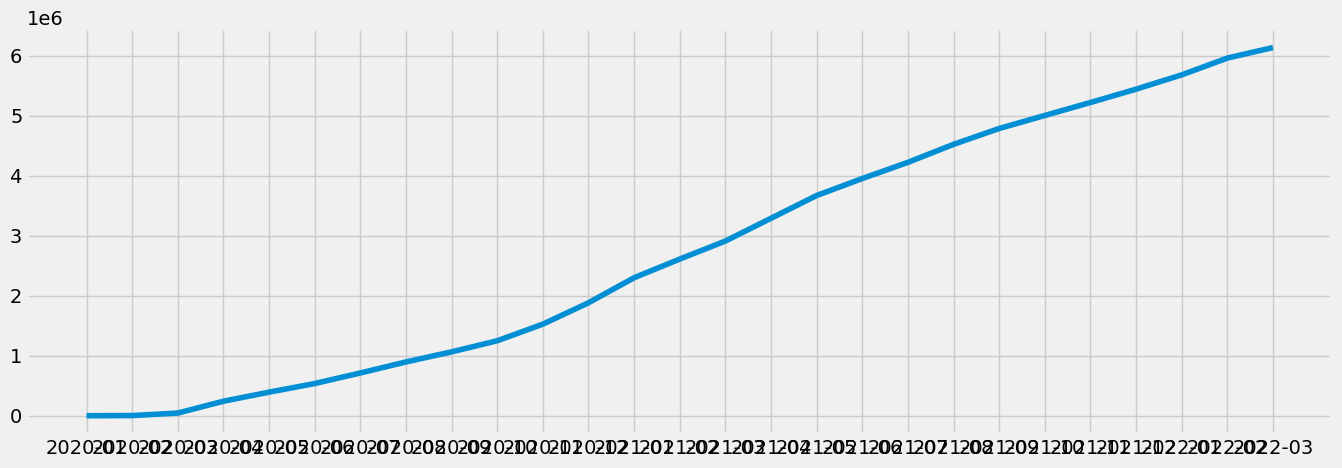

In [33]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df1)

In [34]:
df1_reset = df1.reset_index()

In [35]:
df1_sub = df1_reset.loc[(df1_reset['month_year'] >= '2020-01') & (df1_reset['month_year'] < '2022-03')]

In [36]:
df1_sub.head()

,month_year,total_deaths
0,2020-01,213
1,2020-02,2937
2,2020-03,44843
3,2020-04,241866
4,2020-05,393037


In [37]:
df1_sub.tail()

,month_year,total_deaths
21,2021-10,5001833
22,2021-11,5218055
23,2021-12,5440121
24,2022-01,5678240
25,2022-02,5957884


In [38]:
# Set the "month_year" column as the index
from datetime import datetime

df1_sub['datetime'] = pd.to_datetime(df1_sub['month_year'])
df1_sub = df1_sub.set_index('datetime')
df1_sub.drop(['month_year'], axis=1, inplace=True)
df1_sub.head()

,total_deaths
datetime,
2020-01-01,213
2020-02-01,2937
2020-03-01,44843
2020-04-01,241866
2020-05-01,393037


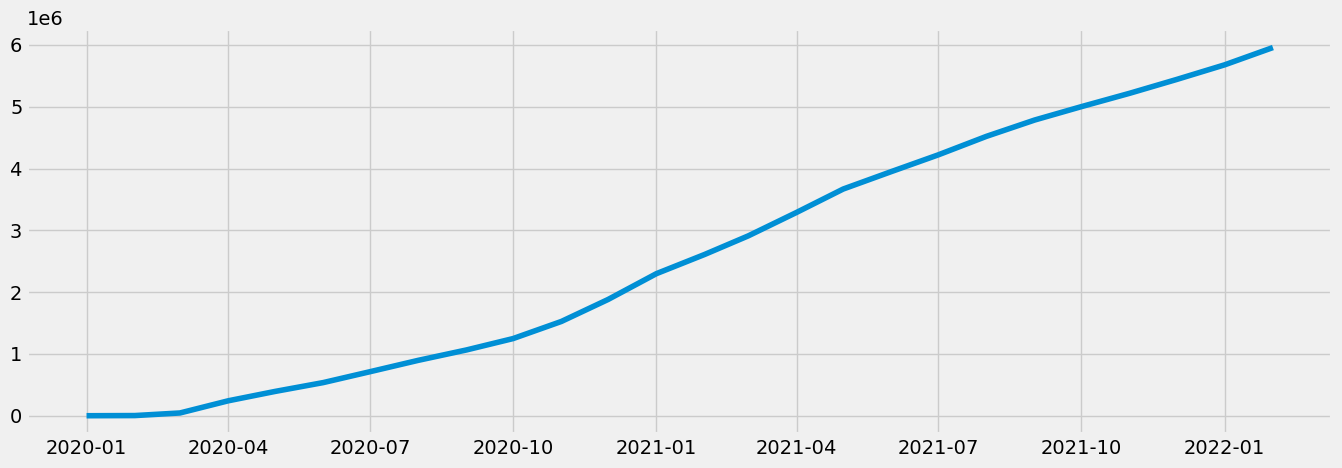

In [39]:
# Plot the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df1_sub)

In [40]:
df1_sub.isnull().sum()

total_deaths    0
dtype: int64

In [41]:
dups1 = df1_sub.duplicated()
dups1.sum()

0

## 3. Time-series analysis: decomposition

In [42]:
# Decompose the time series using an additive model
decomposition1 = sm.tsa.seasonal_decompose(df1_sub, model='additive')

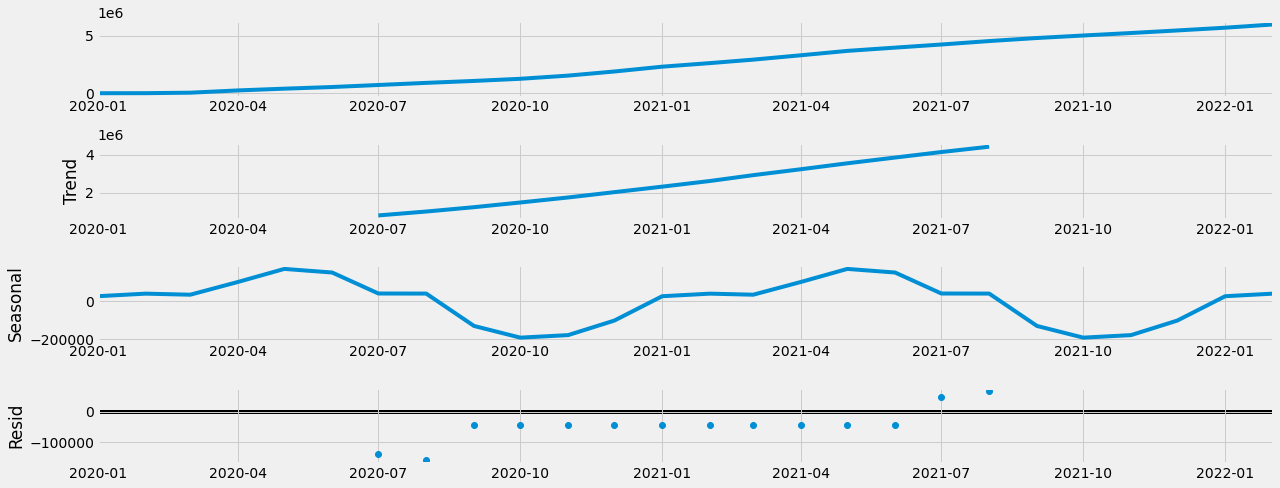

In [43]:
decomposition1.plot()
plt.show()

The first chart is the 'level', or the data with all its compositions - this shows a gradual increase from about April 2020.

The second chart indicates the 'trend' of the data. This data shows an upward trend from at least the middle of 2020.

The third chart indicates 'seasonality'. This data does not have a lot of data points and also does not date back very far. It does however seem as though it has seasonality as the values seem to increase around the same time every year.

The last chart is residual noise.

## 4. Testing for Stationarity

In [44]:
dickey_fuller(df1_sub['total_deaths'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.764714
p-value                         0.829268
Number of Lags Used             3.000000
Number of Observations Used    22.000000
Critical Value (1%)            -3.769733
Critical Value (5%)            -3.005426
Critical Value (10%)           -2.642501
dtype: float64


Test Statistic is bigger than Critical Value, thus data is non-stationary.

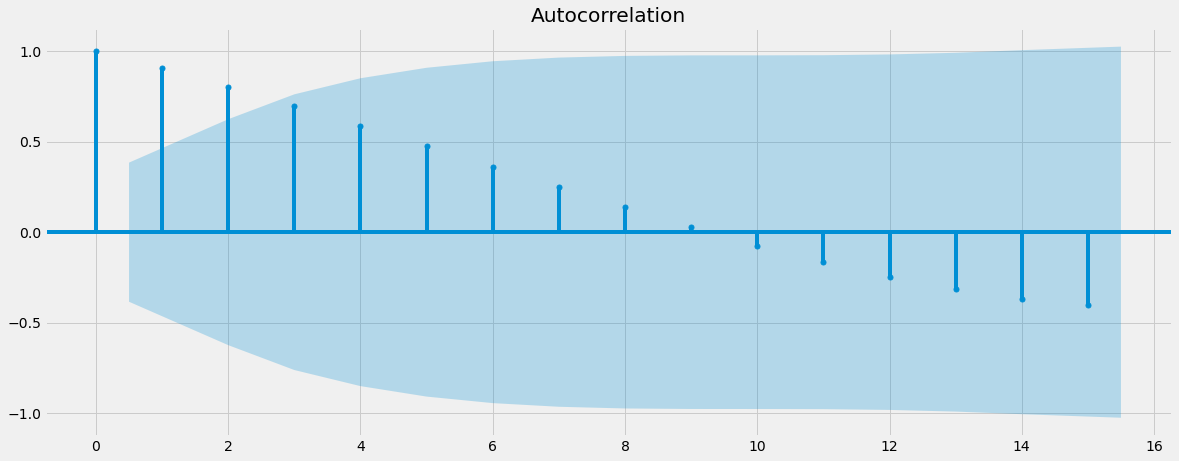

In [45]:
plot_acf(df1_sub)
plt.show()

## 5. Stationarizing COVID-19 Deaths data

In [46]:
df1_diff = df1_sub - df1_sub.shift(1)

In [47]:
df1_diff.dropna(inplace = True)

In [48]:
df1_diff.head()

,total_deaths
datetime,
2020-02-01,2724.0
2020-03-01,41906.0
2020-04-01,197023.0
2020-05-01,151171.0
2020-06-01,143308.0


In [49]:
df1_diff.tail()

,total_deaths
datetime,
2021-10-01,216495.0
2021-11-01,216222.0
2021-12-01,222066.0
2022-01-01,238119.0
2022-02-01,279644.0


In [50]:
df1_diff.columns

Index(['total_deaths'], dtype='object')

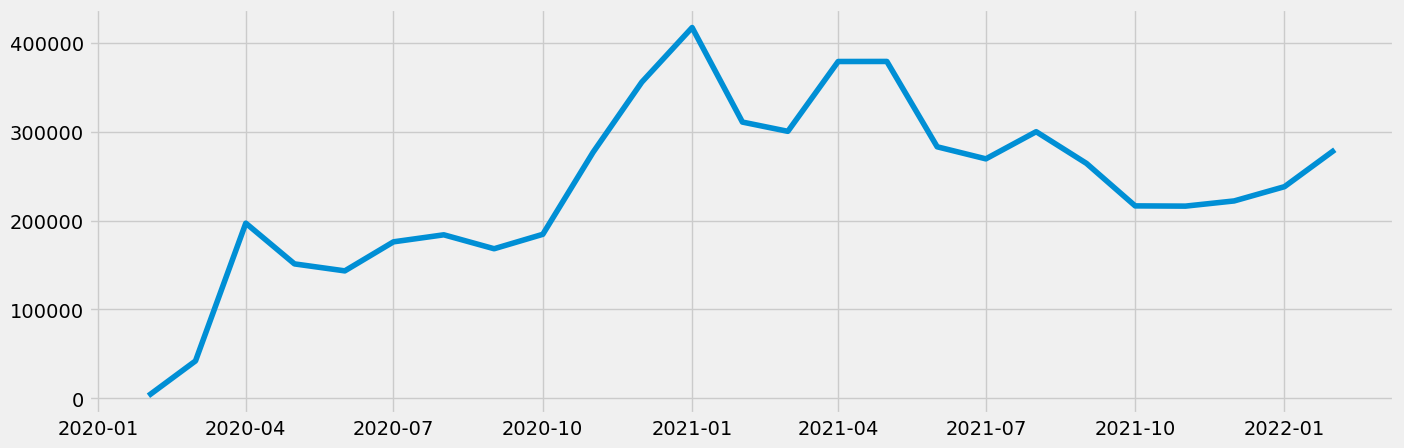

In [51]:
# Check what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df1_diff)

In [52]:
dickey_fuller(df1_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -5.764965e+00
p-value                        5.560052e-07
Number of Lags Used            9.000000e+00
Number of Observations Used    1.500000e+01
Critical Value (1%)           -3.964443e+00
Critical Value (5%)           -3.084908e+00
Critical Value (10%)          -2.681814e+00
dtype: float64


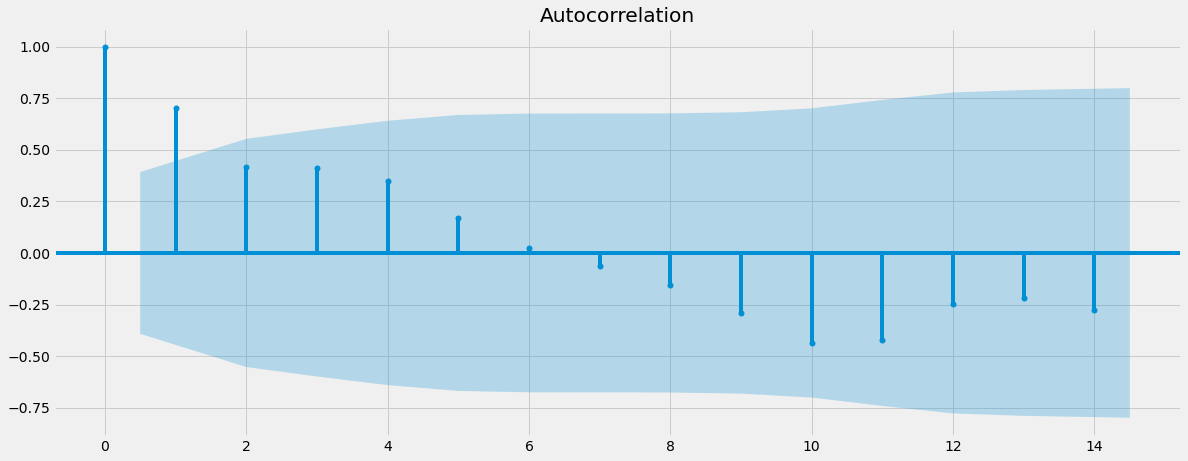

In [53]:
plot_acf(df1_diff)
plt.show()

#### I want to add the bonus task here but need advice first. Should I rather source other data? I tried doing the first step of forecasting (partial autocorrelations) but it gives an error. I think I might not have enough data or at least not for a long enough period.